# Sentence Mapper

In [328]:
%load_ext autoreload
%autoreload 2

import logging

import matplotlib.pyplot as plt
import numpy as np
from rich import print
from datasets import load_dataset


from src.pipeline import SentenceMapperPipeline
from src.visualization import SentenceMapperVisualizer
from src.sentence_processor import SentenceProcessor
from src.map_reduce_summarizer import MapReduceSummarizer

# Suppress langchain text splitter warnings
logging.getLogger('langchain_text_splitters.base').setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get Some Data

For this example, we will use one report from the **GovReports dataset**, which is a long document summarization dataset, with about 19.5k reports published by the U.S. Government Accountability Office (GAO) and Congressional Research Service (CRS).

They cover researches on a broad range of national policy issues, including health care, education, national security, economics, and the environment.


Reference: https://arxiv.org/pdf/2104.02112

## Multi-LexSum

Is a collection of 9,280 such legal case summaries. It presents a challenging multi-document summarization task given the long length of the source documents, often exceeding two hundred pages per case. Experts—lawyers and law students—are trained to follow carefully created guidelines, and their work is reviewed by an additional expert to ensure quality.

Reference: Shen et al. 2022 https://arxiv.org/pdf/2206.10883

In [342]:
# Download one sample from the train split.

split = "train"
index = 0

govreport = load_dataset("ccdv/govreport-summarization", split=f"{split}[:100]")
report = govreport[index]["report"]
reference_summary = govreport[index]["summary"]
print(f"Report:\n{report[:500]}...\n")
print(f"Reference Summary:\n{reference_summary[:500]}...\n")

#multi_lexsum = load_dataset("allenai/multi_lexsum", name="v20230518")

# Download multi_lexsum locally and load it as a Dataset object 

#example["sources"] # A list of source document text for the case

Report:
The structure of the armed forces is based on the Total Force concept, which recognizes that all elements of the 
structure—active duty military personnel, reservists, defense contractors, host nation military and civilian 
personnel, and DOD federal civilian employees—contribute to national defense. In recent years, federal civilian 
personnel have deployed along with military personnel to participate in Operations Joint Endeavor, conducted in the
countries of Bosnia-Herzegovina, Croatia, and Hung...

Reference Summary:
As the Department of Defense (DOD) has expanded its involvement in overseas military operations, it has grown 
increasingly reliant on its federal civilian workforce to support contingency operations. The Senate Armed Services
Committee required GAO to examine DOD's policies concerning the health care for DOD civilians who deploy in support
of contingency operations in Afghanistan and Iraq. GAO analyzed over 3,400 deployment-related records for deployed 
federal civilians and interviewed departmen...

## Sentence Processor

Splits the full document into sentences, then for each sentence builds a centered context window of complete surrounding sentences (excluding the target sentence itself) up to a character budget. Cosine similarity is
computed between the sentence embedding and its context embedding, giving a clean representativeness signal without self-overlap artifacts.

It requires 2 parameters: 

- context_budget: Maximum character budget for the context window surrounding each sentence (default: 2048)
- min_sentence_length: Minimum sentence length in characters. Shorter sentences are merged (default: 256)
 

SentenceProcessor uses model2vec to get embeddings super fast. 

Some domains may use specific abbreviations or prefixes that can confuse the sentence splitter. These prefixes can be passed in custom_parameters, so they are do not end sentences.


For the GovReports dataset, we can add some common abbreviations:
- **U.S.** (United States)
- **H.R.** (House Resolution)
- **H.Rept.** (House Report)
- **P.L.** (Public Law)
- **S.** (Senate bill)

In [330]:
custom_parameters = {
    "prefixes": [
        "H.R", "H.Rept", "S", "P.L", "Rep", "Sen", "S.Rept",
        "U.S", "N.Y", "Calif", "U.N"
    ],
    "additional_replacements": {
        "U.": "U<prd>",
        "S.": "S<prd>",
        "U.S.": "U<prd>S<prd>",
        "U.S.A.": "U<prd>S<prd>A<prd>",
        "i.e.": "i<prd>e<prd>",
        "e.g.": "e<prd>g<prd>",
        "Ph.D.": "Ph<prd>D<prd>",
        "et al.": "et<prd>al<prd>",
    }
}

# Initialize processor with custom splitter for government reports
processor = SentenceProcessor(
    embedding_model_name="minishlab/potion-base-8M",
    context_budget=2048,
    min_sentence_length=256,
    custom_parameters=custom_parameters
)

visualizer = SentenceMapperVisualizer()

Total sentences: 259

Total tokens: 11023

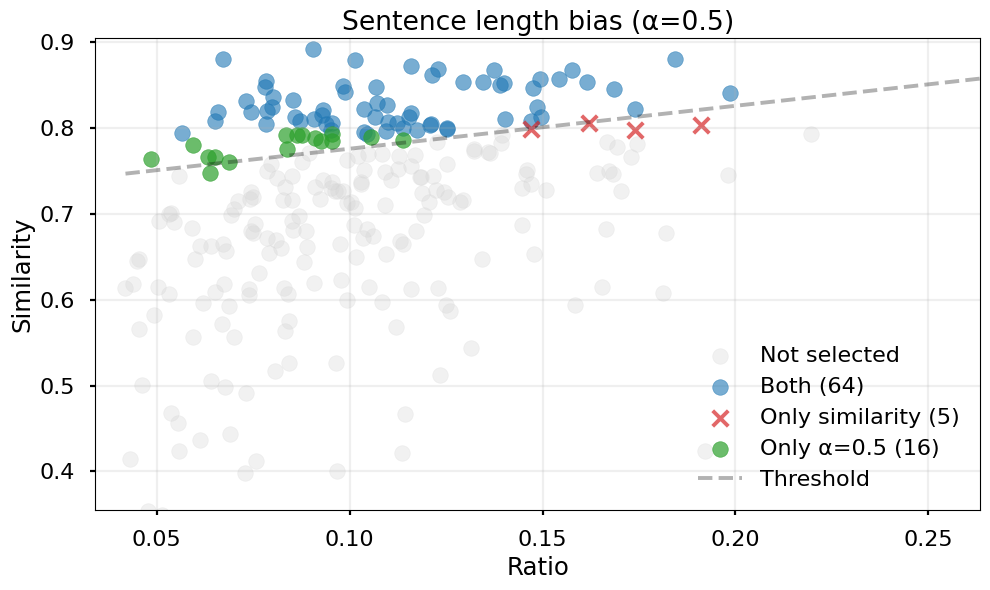

In [331]:
features = processor.compute_document_features(text=report)

print(f"Total sentences: {len(features['similarities'])}")
print(f"Total tokens: {features['total_tokens']}")


fig = SentenceMapperVisualizer.plot_similarity_vs_ratio(
    similarities=features['similarities'],
    ratios=features['ratios'],
    tokens=features['tokens'],
    objective_percentage=0.3,
    length_bias=0.5,
    title="Sentence length bias (α=0.5)",
    save_path="data/img/similarity_vs_ratio_plot.png"
)

plt.show()

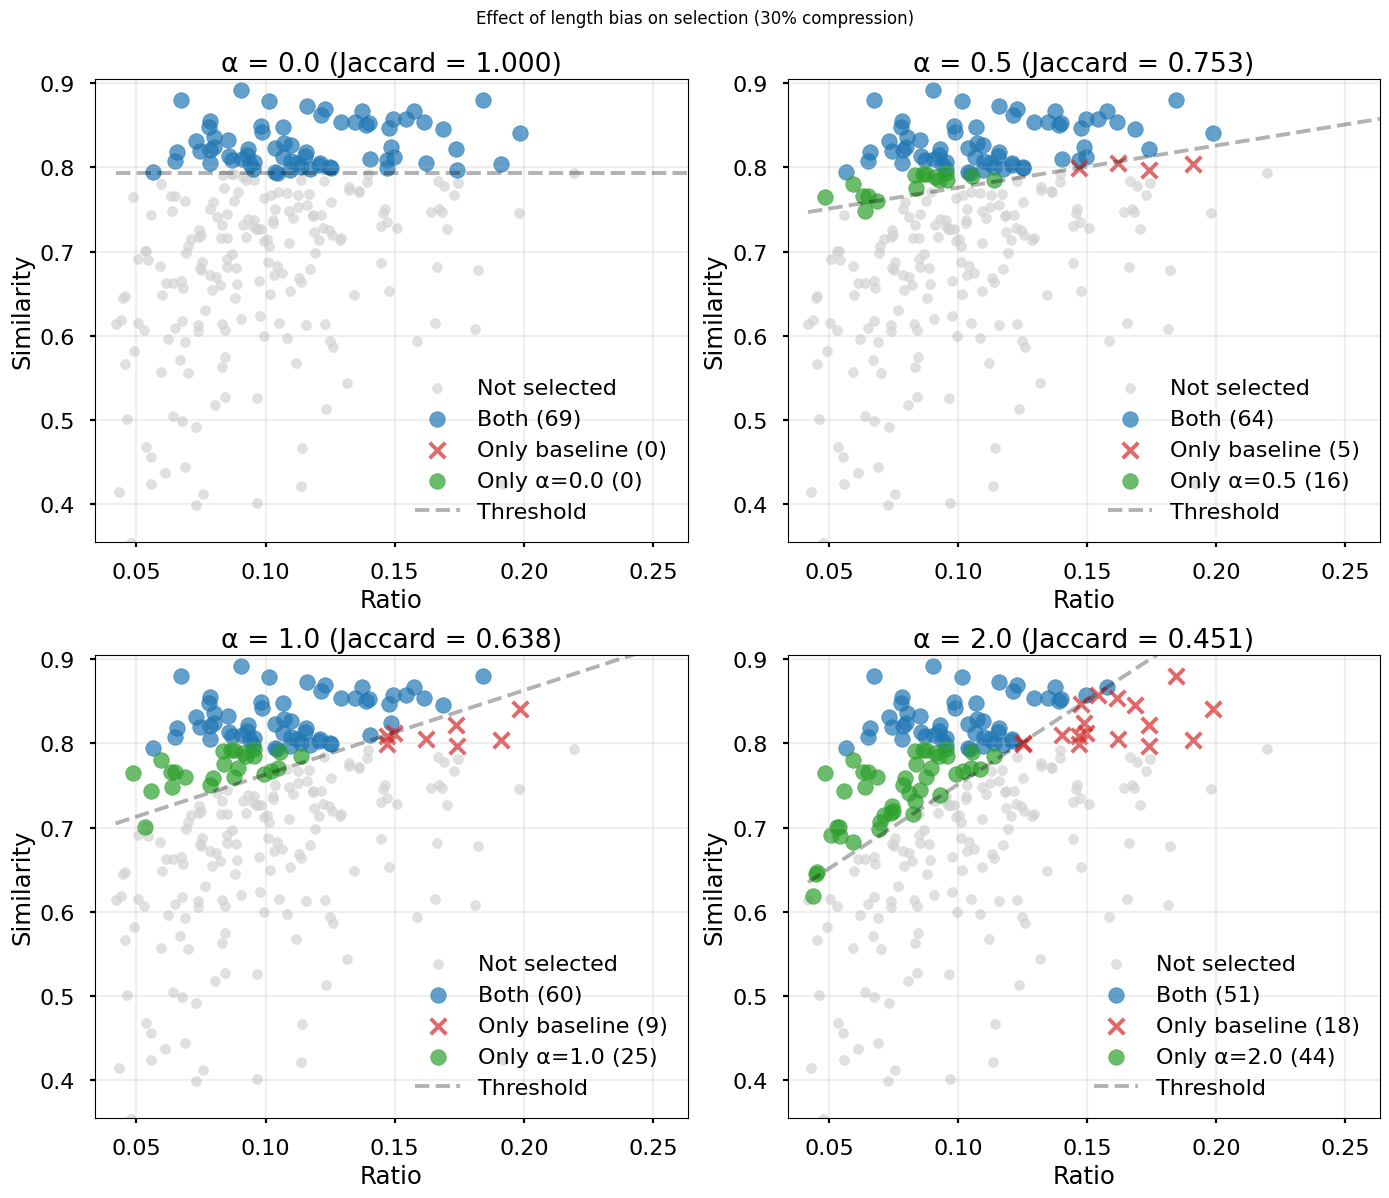

In [332]:
# 2x2 grid comparing different alpha values at 30% compression
fig = visualizer.plot_similarity_vs_ratio_multiple_alphas(
    similarities=features['similarities'],
    ratios=features['ratios'],
    tokens=features['tokens'],
    objective_percentage=0.3,
    alphas=[0.0, 0.5, 1.0, 2.0],
    title="Effect of length bias on selection (30% compression)",
    save_path="data/img/similarity_vs_ratio_plot_multiple_alphas.png"
)
plt.show()

## Scoring & Selection

Each sentence is scored by:

```
score = similarity - α × ratio
```

Where `α` (length_bias, default 0.5) is a linear penalty that mildly favours shorter sentences at equal similarity. With `α = 0`, this is pure similarity ranking.

The additive form composes naturally with future bias terms (e.g. `+ β × query_similarity` for semantic-biased extraction).

Sentences are ranked by score and greedily selected until the token budget is reached.

## Extract the best sentences

`SentenceMapperPipeline.process_document` computes features, scores, and selects the top sentences to fill the token budget.

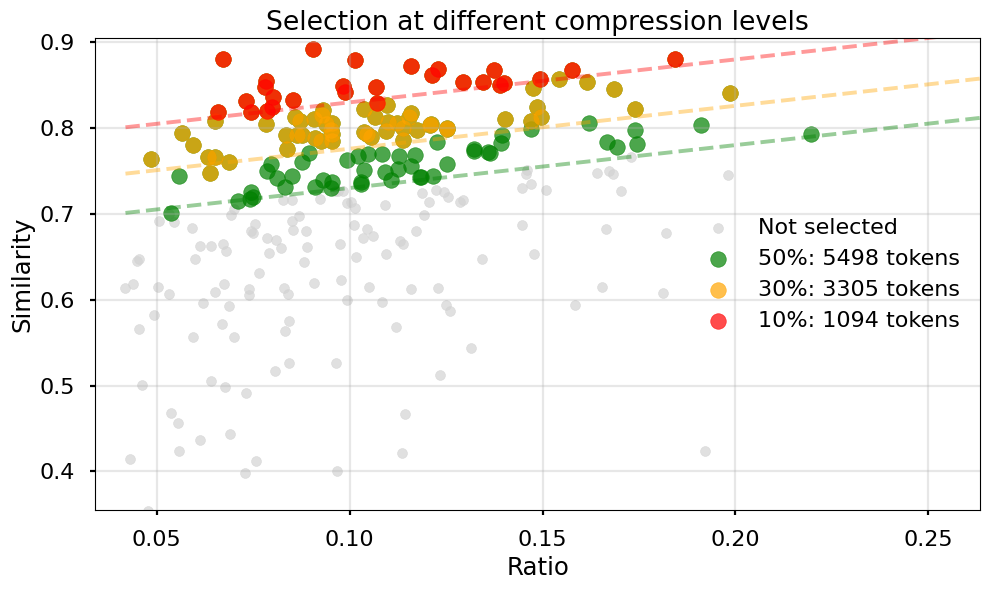

In [333]:
# Initialize pipeline with custom splitter
pipeline = SentenceMapperPipeline(
    embedding_model_name="minishlab/potion-base-8M",
    context_budget=2048,
    min_sentence_length=256,
    custom_parameters=custom_parameters,
    length_bias=0.5,
)

objective_percentages = [0.1, 0.3, 0.5]

results = []
for pct in objective_percentages:
    r = pipeline.process_document(text=report, objective_percentage=pct)
    results.append(r)

# Show selections at different compression levels
SentenceMapperVisualizer.plot_similarity_vs_ratio_multiple_objectives(
    similarities=features['similarities'],
    ratios=features['ratios'],
    results=results,
    objective_percentages=objective_percentages,
    title="Selection at different compression levels"
)


See the selected sentences highlighted in the HTML file.

In [334]:
result = results[1]  # Get the result for the 30% objective
percentage = objective_percentages[1]

SentenceMapperVisualizer.export_highlighted_text(
    sentences=features['sentences'],
    mask=result['mask'],
    output_path=f"data/html/{split}_{index}_{percentage*100:.0f}.html"
)

In [335]:
# Display the first 3 chunks with highlighted sentences
SentenceMapperVisualizer.display_highlighted_text(
    sentences=result['sentences'],
    mask=result['mask'],
    title=f"Selected Sentences ({percentage*100:.0f}% compression)",
    dark_mode=True,
    max_display_tokens=500
)

In [336]:
# Interactive plot — baseline vs length-biased with sentence hover
visualizer = SentenceMapperVisualizer()

fig = visualizer.plot_similarity_vs_ratio_interactive(
    similarities=features["similarities"],
    ratios=features["ratios"],
    tokens=features["tokens"],
    sentences=result["sentences"],
    objective_percentage=percentage,
    length_bias=result["length_bias"],
    title=f"Baseline vs α={result['length_bias']} ({percentage:.0%} target)",
)

## Map - Reduce Summarization

Traditional map-reduce is token expensive. Summarizing section into intermediate summaries (map step), and then generating the final summary is expensive.

After extracting the most information-dense sentences, we can pass them to a LLM to generate a summary spanning the whole document. 
LLM's nowadays are intelligent enough to understand the document even with 70-80% missing context. 


In [317]:
summarizer = MapReduceSummarizer(
    summarize_model="gpt-4.1",
    judge_model="gpt-5-mini",
)

In [311]:
llm_summary = summarizer.summarize_with_llm(text=result["selected_text"])

In [312]:
# Compare with the human reference summary
print("\n[bold]Generated Summary:[/bold]\n")
print(llm_summary)
print("\n[bold]Reference Summary:[/bold]\n")
print(reference_summary)

Generated Summary:

The Department of Defense (DOD) established the emergency-essential program in 1985 to ensure that federal civilian
employees could be deployed to combat zones and perform critical support functions. To safeguard the health of 
deployed civilian personnel, DOD implemented force health protection and surveillance policies focused on 
assessing, reducing, and preventing health risks. These policies mandate that all deploying civilians complete 
pre-deployment health assessment forms within 30 days of deployment, with health care providers reviewing them to 
confirm fitness and identify any need for further evaluation. Pre-deployment and post-deployment health 
assessments, as well as required immunizations, are key parts of these policies, aiming to verify medical readiness
and address health or exposure concerns arising from deployments in theaters such as Afghanistan and Iraq.

In a comprehensive review of federal civilian deployment records from selected DOD components, it was found that 
while most records complied with the health assessment requirements, some gaps remained. Out of 3,771 deployment 
records reviewed, 52 lacked documentation of pre-deployment health assessments, and 285 were missing evidence of at
least one required immunization. Army component locations demonstrated especially strong compliance, but these 
disparities indicated that DOD’s policies were not being fully and consistently implemented across all components. 
DOD also lacked mechanisms to centrally track or report the locations and movements of its deployed civilian 
personnel, limiting oversight and accountability regarding deployment and associated health risks.

Recognizing these shortcomings, DOD’s Office of the Under Secretary of Defense for Personnel and Readiness issued 
revised policy and program guidance in August 2006, calling for more comprehensive and centralized deployment and 
health information for federal civilians. However, while the new policy included requirements for components to 
report specific health and location data, it did not establish an oversight or quality assurance mechanism to 
ensure complete and consistent implementation. In comparison, previous assessments and a related legislative 
mandate prompted DOD to create a similar oversight mechanism to monitor force health protection for military 
servicemembers.

With respect to medical care, DOD federal civilians deployed to combat zones receive care through the military 
health system’s four levels of care if injured or ill, and can claim workers’ compensation benefits under the 
Federal Employees’ Compensation Act if eligible. A sample review of seven compensation claims (from a universe of 
83) for deployed civilians found that, in all cases, the individuals had received medical care consistent with DOD 
policies, both in the theater of operations and upon return to the United States.

Compensation and benefits for DOD federal civilian personnel differ in several respects from those for military 
personnel. Both groups are eligible for compensation to reflect the risks and conditions of deployment, but the 
types and amounts of special pays and allowances vary. For example, federal civilians deployed to Afghanistan and 
Iraq are eligible for post (hardship) differential and danger pay, each equivalent to 35 percent of base salary, 
while military personnel may also receive family separation allowances—a benefit not available to civilians. 
Conversely, federal civilians can receive premium pay, such as overtime and night differential, not available to 
the military. Modeling compensation scenarios showed that, depending on pay grade and deployment circumstances, 
overall compensation could be higher for civilians than for military personnel in some situations.

Disability benefits in the event of deployment-related injury or illness also differ. Civilian disability 
compensation is based on salary and dependent status, while military personnel receive payments base

Reference Summary:

As the Department of Defense (DOD) has expanded its involvement in overseas military operations, it has grown 
increasingly reliant on its federal civilian workforce to support contingency operations. The Senate Armed Services
Committee required GAO to examine DOD's policies concerning the health care for DOD civilians who deploy in support
of contingency operations in Afghanistan and Iraq. GAO analyzed over 3,400 deployment-related records for deployed 
federal civilians and interviewed department officials to determine the extent to which DOD has established and the
military services and defense agencies (hereafter referred to as DOD components) have implemented (1) force health 
protection and surveillance policies and (2) medical treatment policies and procedures for its deployed federal 
civilians. GAO also examined the differences in special pays and benefits provided to DOD's deployed federal 
civilians and military personnel. DOD has established force health protection and surveillance policies to assess 
and reduce or prevent health risks for its deployed federal civilian personnel, but it lacks procedures to ensure 
implementation. Our review of over 3,400 deployment records at eight component locations found that components 
lacked documentation that some federal civilian personnel who deployed to Afghanistan and Iraq had received, among 
other things, required pre- and post-deployment health assessments and immunizations. These deficiencies were most 
prevalent at Air Force and Navy locations, and one Army location. As a larger issue, DOD lacked complete and 
centralized data to readily identify its deployed federal civilians and their movement in theater, further 
hindering its efforts to assess the overall effectiveness of its force health protection and surveillance 
capabilities. In August 2006, DOD issued a revised policy which outlined procedures that are intended to address 
these shortcomings. However, these procedures are not comprehensive enough to ensure that DOD will know the extent 
to which its components are complying with existing health protection requirements. In particular, the procedures 
do not establish an oversight and quality assurance mechanism for assessing the implementation of its force health 
protection and surveillance requirements. Until DOD establishes a mechanism to strengthen its force health 
protection and surveillance oversight, it will not be effectively positioned to ensure compliance with its 
policies, or the health care and protection of deployed federal civilians. DOD has also established medical 
treatment policies for its deployed federal civilians which provide those who require treatment for injuries or 
diseases sustained during overseas hostilities with care that is equivalent in scope to that provided to active 
duty military personnel under the DOD military health system. GAO reviewed a sample of seven workers' compensation 
claims (out of a universe of 83) filed under the Federal Employees' Compensation Act by DOD federal civilians who 
deployed to Iraq. GAO found in three cases where care was initiated in theater, that the affected civilians had 
received treatment in accordance with DOD's policies. In all seven cases, DOD federal civilians who requested care 
after returning to the United States had, in accordance with DOD's policies, received medical examinations and/or 
treatment for their deployment-related injuries or diseases through either military or civilian treatment 
facilities. DOD provides certain special pays and benefits to its deployed federal civilians, which generally 
differ in type and/or amount from those provided to deployed military personnel. For example, both civilian and 
military personnel are eligible to receive disability benefits for deployment-related injuries; however, the type 
and amount of these benefits vary, and some are unique to each group. Further, while the survivors of deceased 
federal civilian and military personnel ge

In [313]:
from src.map_reduce_summarizer import calculate_rouge_scores

print(f"Input length: {len(report)} characters")
print(f"Extracted sentences lenght: {len(result["selected_text"])}")
print(f"Reference summary length: {len(reference_summary)} characters")
print(f"Generated summary lenght: {len(llm_summary)}")

rouge_scores = calculate_rouge_scores(reference_summary, llm_summary)

print(f"  ROUGE-1 F1: {rouge_scores['rouge1']:.4f}")
print(f"  ROUGE-2 F1: {rouge_scores['rouge2']:.4f}")
print(f"  ROUGE-L F1: {rouge_scores['rougeL']:.4f}")


Input length: 62042 characters

Extracted sentences lenght: 19320

Reference summary length: 4074 characters

Generated summary lenght: 5787

ROUGE-1 F1: 0.5822

ROUGE-2 F1: 0.1948

ROUGE-L F1: 0.2365

## LLM-Judge and Future Work

We can use a LLM-as-a-Judge to identify the most salient differences with the reference summary

In the future, SentenceMapper will support the use of a "semantic-bias". A list of keywords or keyphrases that
are relevant for the dataset. They should increase the likelihood of sentences containing them to be extracted.

The LLM-as-a-Judge model can also suggest guidelines for the summarizer.
This infomation can be used to improve the summarization prompt.

Evaluate a small sample of summaries of the dataset, to get a representative list of both, keywords and guideance. Implementing both strategies should improve the quality of the summaries.

In [318]:
judge_evaluation = summarizer.judge_with_llm(
        generated_summary=llm_summary, 
        reference_summary=reference_summary,
        compression_ratio=30,
    )

print("[bold]Strengths:[/bold]", judge_evaluation.get("strengths", "N/A"))
print("\n[bold]Gaps:[/bold]", judge_evaluation.get("gaps", "N/A"))
print("\n[bold]Semantic bias:[/bold]", judge_evaluation.get("semantic_bias", "N/A"))
print("\n[bold]Guidance:[/bold]", judge_evaluation.get("guidance", "N/A"))
print("\n[bold]Overall score:[/bold]", judge_evaluation.get("overall_score", "N/A"))

Strengths: The generated summary captures the report's main themes: DOD force health protection and surveillance 
policies for deployed civilian employees, gaps in implementation and documentation, the lack of centralized 
tracking of deployed civilians, issuance of revised August 2006 policy guidance, equivalence of medical treatment 
for deployed civilians, and differences in compensation, disability, and survivor benefits between civilians and 
military personnel. It also summarizes the review methodology (deployment record review and workers' compensation 
case review) and is generally clear and well organized.

Gaps: Important issues from the reference that are missing or misrepresented: (1) The generated summary misstates 
or contradicts key findings about which components had the most prevalent deficiencies — the reference highlights 
that deficiencies were most prevalent at Air Force and Navy locations (and one Army location), whereas the 
generated text portrays Army locations as especially strong. (2) The workers' compensation sample findings are 
misreported: the reference specifies that in three of the cases care was initiated in theater and those cases 
complied with policy, and that all seven who requested care after return received examinations/treatment; the 
generated summary overgeneralizes that all cases received care both in theater and upon return. (3) The generated 
text includes inconsistent and likely incorrect counts (mentions 3,771 records in one place and 3,431 elsewhere) 
instead of the reference's “over 3,400”/3,400+ figure. (4) The generated summary adds specific numerical benefit 
amounts and percentages (e.g., 35 percent for hardship/danger pay, dollar amounts for death gratuity and burial) 
that are not present in the reference summary and may be extraneous or unsupported. (5) The generated summary ends 
mid-sentence, leaving the final methodological point incomplete.

Semantic bias:
[
    'health protection and surveillance',
    'implementation and oversight',
    'personnel tracking and data quality',
    'medical treatment and care access',
    'compensation and benefits'
]

Guidance: 1) Preserve accuracy for quantitative and component-specific findings: only include numeric counts, 
percentages, or component comparisons when they are explicitly supported by the source and maintain consistency 
throughout the summary. 2) Explicitly distinguish between policy existence and implementation (what policies 
require versus evidence of compliance), and highlight which organizational components are noncompliant so readers 
understand scope and distribution of problems.

Overall score: 7

## A/B: Additive α=0.5 vs α=0 (pure similarity)

Run the same ROUGE evaluation on 50 GovReport docs, but using the additive formula `score = similarity - α × ratio` with α=0.5 (equivalent to multiplicative α=0.1).

In [214]:
from rouge_score import rouge_scorer
import pandas as pd
import numpy as np

def compare_additive_bias(
    dataset,
    processor,
    objective_percentage: float = 0.3,
    alphas: list[float] = [0.0, 0.5],
):
    """Compare additive length_bias values: score = similarity - α × ratio."""
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    records = []

    for i, example in enumerate(dataset):
        text = example["report"]
        reference = example["summary"]

        # Compute features once per document
        features = processor.compute_document_features(text)
        total_tokens = int(np.sum(features["tokens"]))
        budget = total_tokens * objective_percentage

        row = {"doc": i}

        for alpha in alphas:
            scores = features["similarities"] - alpha * features["ratios"]

            # Greedy fill
            mask = np.zeros(len(scores), dtype=bool)
            current = 0
            for idx in np.argsort(-scores):
                if current + features["tokens"][idx] > budget:
                    continue
                mask[idx] = True
                current += features["tokens"][idx]

            selected_text = processor.select_sentences_with_separators(
                features["sentences"], mask.astype(int)
            )

            rouge = scorer.score(reference, selected_text)
            prefix = f"a{alpha}"
            row[f"{prefix}_tokens"] = int(np.sum(features["tokens"][mask]))
            row[f"{prefix}_rouge1"] = rouge["rouge1"].fmeasure
            row[f"{prefix}_rouge2"] = rouge["rouge2"].fmeasure
            row[f"{prefix}_rougeL"] = rouge["rougeL"].fmeasure

        records.append(row)
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(dataset)} reports...")

    return pd.DataFrame(records)

df_add = compare_additive_bias(
    dataset=govreport,
    processor=processor,
    objective_percentage=0.3,
    alphas=[0.0, 0.5],
)

Processed 10/50 reports...

Processed 20/50 reports...

Processed 30/50 reports...

Processed 40/50 reports...

Processed 50/50 reports...

In [215]:
# Summary: additive α=0.5 vs α=0
summary_add = pd.DataFrame({
    "α = 0 (similarity only)": {
        "ROUGE-1": df_add["a0.0_rouge1"].mean(),
        "ROUGE-2": df_add["a0.0_rouge2"].mean(),
        "ROUGE-L": df_add["a0.0_rougeL"].mean(),
        "Avg tokens": df_add["a0.0_tokens"].mean(),
    },
    "Additive α = 0.5": {
        "ROUGE-1": df_add["a0.5_rouge1"].mean(),
        "ROUGE-2": df_add["a0.5_rouge2"].mean(),
        "ROUGE-L": df_add["a0.5_rougeL"].mean(),
        "Avg tokens": df_add["a0.5_tokens"].mean(),
    },
})
summary_add["Δ (α=0.5 − α=0)"] = summary_add["Additive α = 0.5"] - summary_add["α = 0 (similarity only)"]

print(f"Additive A/B over {len(df_add)} reports at 30% compression\n")
print(summary_add.to_string(float_format=lambda x: f"{x:.4f}"))

# Win rates
print(f"\n--- Win rates (additive α=0.5 > α=0) ---")
for metric in ["rouge1", "rouge2", "rougeL"]:
    wins = (df_add[f"a0.5_{metric}"] > df_add[f"a0.0_{metric}"]).sum()
    losses = (df_add[f"a0.5_{metric}"] < df_add[f"a0.0_{metric}"]).sum()
    ties = (df_add[f"a0.5_{metric}"] == df_add[f"a0.0_{metric}"]).sum()
    print(f"  {metric.upper():8s}: α=0.5 wins {wins}, α=0 wins {losses}, ties {ties}")

# Compare with multiplicative results (from earlier df)
print(f"\n--- Cross-comparison: Additive α=0.5 vs Multiplicative α=0.1 ---")
print(f"{'Metric':>10s}  {'Mult α=0.1':>12s}  {'Add α=0.5':>12s}  {'Δ':>8s}")
print("-" * 48)
for metric in ["rouge1", "rouge2", "rougeL"]:
    mult_val = df[f"a0.1_{metric}"].mean()
    add_val = df_add[f"a0.5_{metric}"].mean()
    print(f"  {metric.upper():8s}  {mult_val:>12.4f}  {add_val:>12.4f}  {add_val - mult_val:>+8.4f}")

Additive A/B over 50 reports at 30% compression

α = 0 (similarity only)  Additive α = 0.5  Δ (α=0.5 − α=0)
ROUGE-1                      0.3465            0.3475           0.0010
ROUGE-2                      0.1639            0.1649           0.0010
ROUGE-L                      0.1609            0.1638           0.0029
Avg tokens                2580.9600         2581.1400           0.1800

--- Win rates (additive α=0.5 > α=0) ---

ROUGE1  : α=0.5 wins 27, α=0 wins 22, ties 1

ROUGE2  : α=0.5 wins 26, α=0 wins 23, ties 1

ROUGEL  : α=0.5 wins 32, α=0 wins 17, ties 1

--- Cross-comparison: Additive α=0.5 vs Multiplicative α=0.1 ---

Metric    Mult α=0.1     Add α=0.5         Δ

------------------------------------------------

ROUGE1          0.3475        0.3475   -0.0000

ROUGE2          0.1652        0.1649   -0.0003

ROUGEL          0.1638        0.1638   -0.0000

## A/B: Embedding Model Comparison

All four minishlab **potion** models are distilled from the same teacher (`bge-base-en-v1.5`) and differ only in vocabulary size / parameter count:

| Model | Params | MTEB Avg (English) |
|---|---|---|
| `potion-base-2M` | 2 M | 44.77 |
| `potion-base-4M` | 4 M | 48.23 |
| `potion-base-8M` | 8 M | 50.03 |
| `potion-base-32M` | 32 M | 51.66 |

**Hypothesis:** Because SentenceMapper only uses *relative* cosine similarity (sentence vs. its own context window), the ranking of sentences should be largely model-invariant.  A weaker model produces noisier embeddings, but the *ranking* of sentences by representativeness may be preserved — meaning ROUGE scores stay flat across models.

**Design:**
- Same 50 GovReport documents, 30% compression, additive α = 0.5.
- One `SentenceProcessor` per model (sentence splitting is deterministic — only embeddings change).
- ROUGE-1 / ROUGE-2 / ROUGE-L of selected text vs. human reference.
- Pairwise Jaccard overlap of selected sentence sets to quantify agreement.
- Wall-clock embedding time per model.

In [301]:
from src.ab_testing import compare_embedding_models

MODELS = [
    "minishlab/potion-base-2M",
    "minishlab/potion-base-4M",
    "minishlab/potion-base-8M",
    "minishlab/potion-base-32M",
]

ALPHA = 0.5
OBJECTIVE_PCT = 0.3

# Pre-load one processor per model (sentence splitting is shared config)
processors = {}
for model_name in MODELS:
    print(f"Loading {model_name}...")
    processors[model_name] = SentenceProcessor(
        embedding_model_name=model_name,
        context_budget=2048,
        min_sentence_length=256,
        custom_parameters=custom_parameters,   # reuse GovReport abbreviations
    )
print("All models loaded.")

Loading minishlab/potion-base-2M...

Loading minishlab/potion-base-4M...

model.safetensors:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/202 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading minishlab/potion-base-8M...

Loading minishlab/potion-base-32M...

All models loaded.

In [302]:
df_models = compare_embedding_models(
    dataset=govreport,
    processors=processors,
    objective_percentage=OBJECTIVE_PCT,
    alpha=ALPHA,
)


Processed 10/50 reports...

Processed 20/50 reports...

Processed 30/50 reports...

Processed 40/50 reports...

Processed 50/50 reports...

In [303]:
from src.ab_testing import print_embedding_model_summary

model_shorts = [m.split("/")[-1] for m in MODELS]
print_embedding_model_summary(df_models, model_shorts, OBJECTIVE_PCT, ALPHA)


Embedding model A/B over 50 reports at 30% compression (α=0.5)

potion-base-2M  potion-base-4M  potion-base-8M  potion-base-32M
ROUGE-1                 0.3481          0.3490          0.3475           0.3476
ROUGE-2                 0.1643          0.1663          0.1649           0.1635
ROUGE-L                 0.1618          0.1644          0.1638           0.1617
Avg tokens           2580.2800       2581.4600       2581.1400        2580.9800
Embed time (s)          0.0627          0.0623          0.0654           0.0729

--- Average pairwise Jaccard overlap ---

potion-base-2M_vs_potion-base-4M             : 0.7591

potion-base-2M_vs_potion-base-8M             : 0.6830

potion-base-2M_vs_potion-base-32M            : 0.6167

potion-base-4M_vs_potion-base-8M             : 0.8185

potion-base-4M_vs_potion-base-32M            : 0.6983

potion-base-8M_vs_potion-base-32M            : 0.7619

--- Win counts (best ROUGE-L per document) ---

potion-base-2M     17
potion-base-8M     13
potion-base-32M    11
potion-base-4M      9

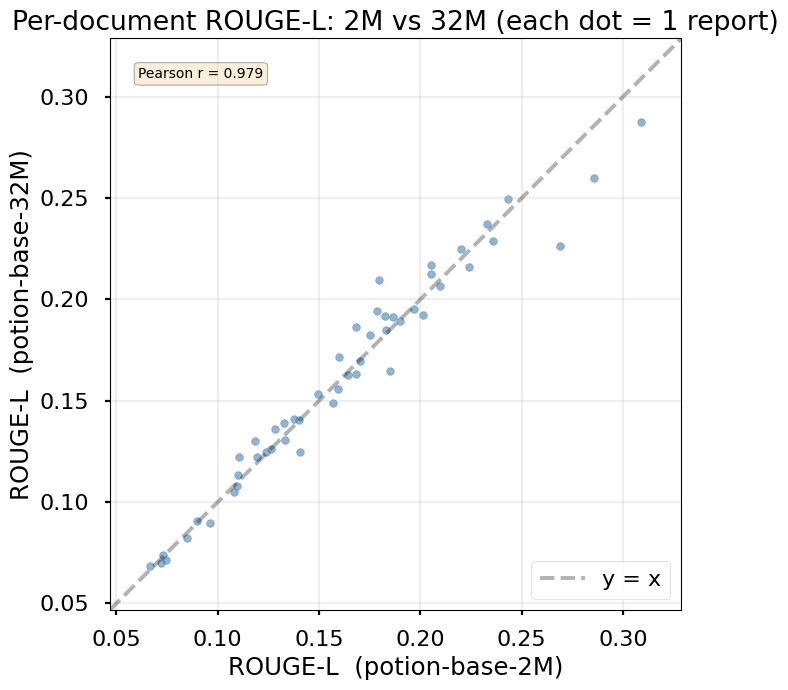

In [305]:
# ── Per-document ROUGE-L scatter: smallest vs largest model ──

fig, ax = plt.subplots(figsize=(7, 7))
x = df_models["potion-base-2M_rougeL"]
y = df_models["potion-base-32M_rougeL"]

ax.scatter(x, y, alpha=0.6, s=30, color="steelblue")
lims = [min(x.min(), y.min()) - 0.02, max(x.max(), y.max()) + 0.02]
ax.plot(lims, lims, "k--", alpha=0.3, label="y = x")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("ROUGE-L  (potion-base-2M)")
ax.set_ylabel("ROUGE-L  (potion-base-32M)")
ax.set_title("Per-document ROUGE-L: 2M vs 32M (each dot = 1 report)")
ax.legend()
ax.set_aspect("equal")
ax.grid(True, alpha=0.2)

# Pearson correlation
corr = np.corrcoef(x, y)[0, 1]
ax.text(0.05, 0.95, f"Pearson r = {corr:.3f}", transform=ax.transAxes,
        fontsize=10, verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.tight_layout()
plt.show()

In [306]:
from src.ab_testing import compute_spearman_rankings, print_spearman_summary

model_shorts = [m.split("/")[-1] for m in MODELS]

df_spearman = compute_spearman_rankings(
    dataset=govreport,
    processors=processors,
    alpha=ALPHA,
)

print_spearman_summary(df_spearman, model_shorts)


Processed 10/50 reports...

Processed 20/50 reports...

Processed 30/50 reports...

Processed 40/50 reports...

Processed 50/50 reports...

Pair    ρ (similarity)     ρ (score)

--------------------------------------------------------------------------------

potion-base-2M vs       potion-base-4M            0.9638        0.9604

potion-base-2M vs       potion-base-8M            0.9364        0.9306

potion-base-2M vs      potion-base-32M            0.8865        0.8762

potion-base-4M vs       potion-base-8M            0.9828        0.9815

potion-base-4M vs      potion-base-32M            0.9405        0.9353

potion-base-8M vs      potion-base-32M            0.9632        0.9602

## A/B: LLM Summary Quality — 2M vs 32M

The previous experiments showed that ROUGE on *extracted text* and Spearman rank correlation are nearly identical across embedding models. But does this hold when we add the LLM abstraction step?

**Design:**
- 10 GovReport documents, 30% compression, α = 0.5.
- For each document, extract sentences with **potion-base-2M** and **potion-base-32M**.
- Pass each extraction to `gpt-4.1` to generate a summary.
- Evaluate with ROUGE (vs human reference) and LLM judge (`gpt-5`).
- Compare scores pairwise across models.

In [319]:
import time
import numpy as np
import pandas as pd
from rouge_score import rouge_scorer

from src.ab_testing import compare_llm_summaries

AB_MODELS = ["minishlab/potion-base-2M", "minishlab/potion-base-32M"]
N_DOCS = 10

# Create a pipeline per model
pipelines = {}
for model_name in AB_MODELS:
    short = model_name.split("/")[-1]
    pipelines[short] = SentenceMapperPipeline(
        embedding_model_name=model_name,
        context_budget=2048,
        min_sentence_length=256,
        custom_parameters=custom_parameters,
        length_bias=ALPHA,
    )
    print(f"Pipeline loaded: {short}")

df_llm_ab = compare_llm_summaries(
    dataset=govreport,
    pipelines=pipelines,
    summarizer=summarizer,
    objective_percentage=OBJECTIVE_PCT,
    n_docs=N_DOCS,
)

print(f"\nDone — {N_DOCS} documents processed.")


Pipeline loaded: potion-base-2M

Pipeline loaded: potion-base-32M

Doc 0: 2M judge=7, 32M judge=7

Doc 1: 2M judge=7, 32M judge=7

Doc 2: 2M judge=7, 32M judge=7

Doc 3: 2M judge=7, 32M judge=7

Doc 4: 2M judge=7, 32M judge=7

Doc 5: 2M judge=7, 32M judge=7

⚠ Empty judge response, retrying (1/2)...

Doc 6: 2M judge=7, 32M judge=7

Doc 7: 2M judge=7, 32M judge=7

Doc 8: 2M judge=7, 32M judge=7

Doc 9: 2M judge=7, 32M judge=7

Done — 10 documents processed.

In [320]:
from src.ab_testing import print_llm_summary_comparison

shorts = [m.split("/")[-1] for m in AB_MODELS]
print_llm_summary_comparison(df_llm_ab, shorts, OBJECTIVE_PCT, ALPHA)


LLM Summary A/B — 10 docs, 30% compression, α=0.5

potion-base-2M  potion-base-32M  Δ (2M − 32M)
ROUGE-1              0.4766           0.4858       -0.0092
ROUGE-2              0.1335           0.1336       -0.0001
ROUGE-L              0.1826           0.1878       -0.0052
Judge score          7.0000           7.0000        0.0000

Doc   2M ROUGE-L   32M ROUGE-L   2M Judge   32M Judge

-------------------------------------------------------

0       0.2204        0.2367          7           7

1       0.1487        0.1634          7           7

2       0.2534        0.2431          7           7

3       0.1881        0.1836          7           7

4       0.1163        0.1075          7           7

5       0.1904        0.2059          7           7

6       0.1980        0.2019          7           7

7       0.1656        0.1667          7           7

8       0.1606        0.1947          7           7

9       0.1847        0.1751          7           7

--- Win rates (2M vs 32M) ---

ROUGE-L: 2M wins 4, 32M wins 6, ties 0

Judge: 2M wins 0, 32M wins 0, ties 10

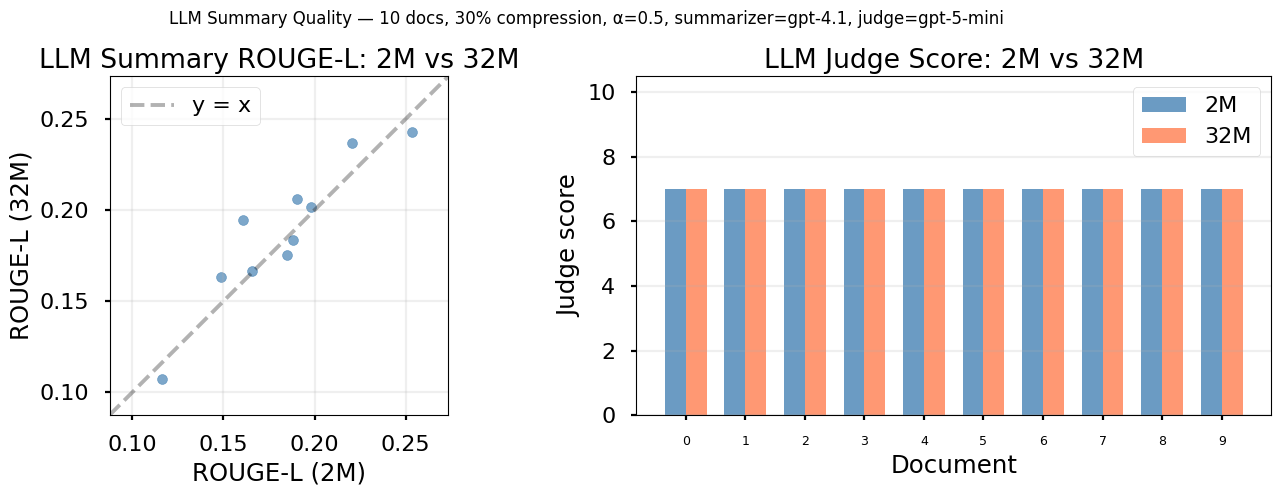

In [321]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Left: ROUGE-L scatter ──
ax = axes[0]
x = df_llm_ab["potion-base-2M_rougeL"]
y = df_llm_ab["potion-base-32M_rougeL"]
ax.scatter(x, y, s=50, alpha=0.7, color="steelblue")
lims = [min(x.min(), y.min()) - 0.02, max(x.max(), y.max()) + 0.02]
ax.plot(lims, lims, "k--", alpha=0.3, label="y = x")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("ROUGE-L (2M)")
ax.set_ylabel("ROUGE-L (32M)")
ax.set_title("LLM Summary ROUGE-L: 2M vs 32M")
ax.set_aspect("equal")
ax.legend()
ax.grid(True, alpha=0.2)

# ── Right: Judge score comparison ──
ax = axes[1]
doc_ids = df_llm_ab["doc"].astype(int)
width = 0.35
x_pos = np.arange(len(doc_ids))
ax.bar(x_pos - width/2, df_llm_ab["potion-base-2M_judge_score"], width,
       label="2M", color="steelblue", alpha=0.8)
ax.bar(x_pos + width/2, df_llm_ab["potion-base-32M_judge_score"], width,
       label="32M", color="coral", alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(doc_ids, fontsize=9)
ax.set_xlabel("Document")
ax.set_ylabel("Judge score")
ax.set_title("LLM Judge Score: 2M vs 32M")
ax.set_ylim(0, 10.5)
ax.legend()
ax.grid(axis="y", alpha=0.2)

fig.suptitle(
    f"LLM Summary Quality — {N_DOCS} docs, {OBJECTIVE_PCT:.0%} compression, "
    f"α={ALPHA}, summarizer={summarizer.summarize_model}, judge={summarizer.judge_model}",
    fontsize=12,
)
plt.tight_layout()
plt.show()

## Experiment: Null Hypothesis — Random vs Similarity-Based Extraction

Before exploring extensions to the scoring formula, we must validate that similarity-based extraction is **better than random selection**.

**Null Hypothesis (H₀):** Random sentence selection achieves the same ROUGE score as similarity-based extraction.

**Alternative Hypothesis (H₁):** Similarity-based extraction achieves higher ROUGE scores.

**Design:**
- For each document, select sentences randomly until we reach approximately the same token budget as the similarity-based method
- Repeat random selection multiple times per document (10 seeds) to account for variance
- Compare ROUGE scores using paired t-test

In [347]:
import numpy as np
from rouge_score import rouge_scorer
from scipy import stats
from tqdm import tqdm

# Parameters
N_BASELINE_DOCS = 100
N_RANDOM_SEEDS = 10  # Repeat random selection per document
OBJECTIVE_PCT_BASELINE = 0.30
ALPHA_BASELINE = 0.5

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Storage for results
similarity_rouge = {'rouge1': [], 'rouge2': [], 'rougeL': []}
random_rouge = {'rouge1': [], 'rouge2': [], 'rougeL': []}

for doc_idx in tqdm(range(N_BASELINE_DOCS), desc="Documents"):
    example = govreport[doc_idx]
    report = example['report']
    reference = example['summary']
    
    # === Similarity-based extraction ===
    features = processor.compute_document_features(report)
    sentences = features['sentences']
    tokens = features['tokens']
    similarities = features['similarities']
    ratios = features['ratios']
    
    total_tokens = tokens.sum()
    target_tokens = int(total_tokens * OBJECTIVE_PCT_BASELINE)
    
    # Compute scores with α
    scores = similarities - ALPHA_BASELINE * ratios
    ranked_indices = np.argsort(-scores)
    
    # Greedy selection up to budget
    selected_sim = []
    current_tokens = 0
    for idx in ranked_indices:
        if current_tokens + tokens[idx] <= target_tokens:
            selected_sim.append(idx)
            current_tokens += tokens[idx]
    
    # Extract text (preserve original order)
    selected_sim_sorted = sorted(selected_sim)
    sim_text = ' '.join([sentences[i] for i in selected_sim_sorted])
    
    # ROUGE for similarity method
    rouge = scorer.score(reference, sim_text)
    similarity_rouge['rouge1'].append(rouge['rouge1'].fmeasure)
    similarity_rouge['rouge2'].append(rouge['rouge2'].fmeasure)
    similarity_rouge['rougeL'].append(rouge['rougeL'].fmeasure)
    
    # === Random selection (average over multiple seeds) ===
    random_r1, random_r2, random_rL = [], [], []
    
    for seed in range(N_RANDOM_SEEDS):
        np.random.seed(doc_idx * 1000 + seed)  # Reproducible
        
        # Shuffle indices and greedily select
        shuffled_indices = np.random.permutation(len(sentences))
        selected_rand = []
        current_tokens = 0
        for idx in shuffled_indices:
            if current_tokens + tokens[idx] <= target_tokens:
                selected_rand.append(idx)
                current_tokens += tokens[idx]
        
        # Extract text (preserve original order)
        selected_rand_sorted = sorted(selected_rand)
        rand_text = ' '.join([sentences[i] for i in selected_rand_sorted])
        
        # ROUGE for this random sample
        rouge = scorer.score(reference, rand_text)
        random_r1.append(rouge['rouge1'].fmeasure)
        random_r2.append(rouge['rouge2'].fmeasure)
        random_rL.append(rouge['rougeL'].fmeasure)
    
    # Average across seeds for this document
    random_rouge['rouge1'].append(np.mean(random_r1))
    random_rouge['rouge2'].append(np.mean(random_r2))
    random_rouge['rougeL'].append(np.mean(random_rL))

print(f"Completed: {N_BASELINE_DOCS} documents, {N_RANDOM_SEEDS} random seeds each")

Documents: 100%|██████████| 100/100 [03:19<00:00,  1.99s/it]


Completed: 100 documents, 10 random seeds each

In [348]:
# Statistical analysis and results
print("=" * 60)
print("NULL HYPOTHESIS TEST: Random vs Similarity-Based Extraction")
print("=" * 60)
print(f"\nN = {N_BASELINE_DOCS} documents, {N_RANDOM_SEEDS} random seeds per doc")
print(f"Compression: {OBJECTIVE_PCT_BASELINE:.0%}, α = {ALPHA_BASELINE}")
print()

# Summary statistics
print(f"{'Method':<12} {'ROUGE-1':>12} {'ROUGE-2':>12} {'ROUGE-L':>12}")
print("-" * 50)

sim_r1 = np.array(similarity_rouge['rouge1'])
sim_r2 = np.array(similarity_rouge['rouge2'])
sim_rL = np.array(similarity_rouge['rougeL'])

rand_r1 = np.array(random_rouge['rouge1'])
rand_r2 = np.array(random_rouge['rouge2'])
rand_rL = np.array(random_rouge['rougeL'])

print(f"{'Similarity':<12} {sim_r1.mean():.4f}±{sim_r1.std()/np.sqrt(len(sim_r1)):.4f}"
      f"   {sim_r2.mean():.4f}±{sim_r2.std()/np.sqrt(len(sim_r2)):.4f}"
      f"   {sim_rL.mean():.4f}±{sim_rL.std()/np.sqrt(len(sim_rL)):.4f}")
print(f"{'Random':<12} {rand_r1.mean():.4f}±{rand_r1.std()/np.sqrt(len(rand_r1)):.4f}"
      f"   {rand_r2.mean():.4f}±{rand_r2.std()/np.sqrt(len(rand_r2)):.4f}"
      f"   {rand_rL.mean():.4f}±{rand_rL.std()/np.sqrt(len(rand_rL)):.4f}")

print()
print("Paired t-test (Similarity vs Random):")
print(f"{'Metric':<10} {'Δ':>8} {'t-stat':>10} {'p-value':>12} {'Significant?':>14}")
print("-" * 56)

for metric, sim_arr, rand_arr in [
    ('ROUGE-1', sim_r1, rand_r1),
    ('ROUGE-2', sim_r2, rand_r2),
    ('ROUGE-L', sim_rL, rand_rL)
]:
    delta = sim_arr.mean() - rand_arr.mean()
    t_stat, p_val = stats.ttest_rel(sim_arr, rand_arr)
    sig = "✓ YES" if p_val < 0.05 else "✗ NO"
    print(f"{metric:<10} {delta:>+.4f} {t_stat:>10.2f} {p_val:>12.2e} {sig:>14}")

# Effect size (Cohen's d for paired samples)
print()
print("Effect sizes (Cohen's d):")
for metric, sim_arr, rand_arr in [
    ('ROUGE-1', sim_r1, rand_r1),
    ('ROUGE-2', sim_r2, rand_r2),
    ('ROUGE-L', sim_rL, rand_rL)
]:
    diff = sim_arr - rand_arr
    d = diff.mean() / diff.std()
    magnitude = "large" if abs(d) > 0.8 else "medium" if abs(d) > 0.5 else "small"
    print(f"  {metric}: d = {d:.3f} ({magnitude})")

============================================================

NULL HYPOTHESIS TEST: Random vs Similarity-Based Extraction

============================================================

N = 100 documents, 10 random seeds per doc

Compression: 30%, α = 0.5

Method            ROUGE-1      ROUGE-2      ROUGE-L

--------------------------------------------------

Similarity   0.3410±0.0140   0.1642±0.0072   0.1639±0.0059

Random       0.3457±0.0139   0.1562±0.0061   0.1547±0.0051

Paired t-test (Similarity vs Random):

Metric            Δ     t-stat      p-value   Significant?

--------------------------------------------------------

ROUGE-1    -0.0047      -3.20     1.86e-03          ✓ YES

ROUGE-2    +0.0080       3.82     2.29e-04          ✓ YES

ROUGE-L    +0.0092       4.81     5.34e-06          ✓ YES

Effect sizes (Cohen's d):

ROUGE-1: d = -0.321 (small)

ROUGE-2: d = 0.384 (small)

ROUGE-L: d = 0.484 (small)

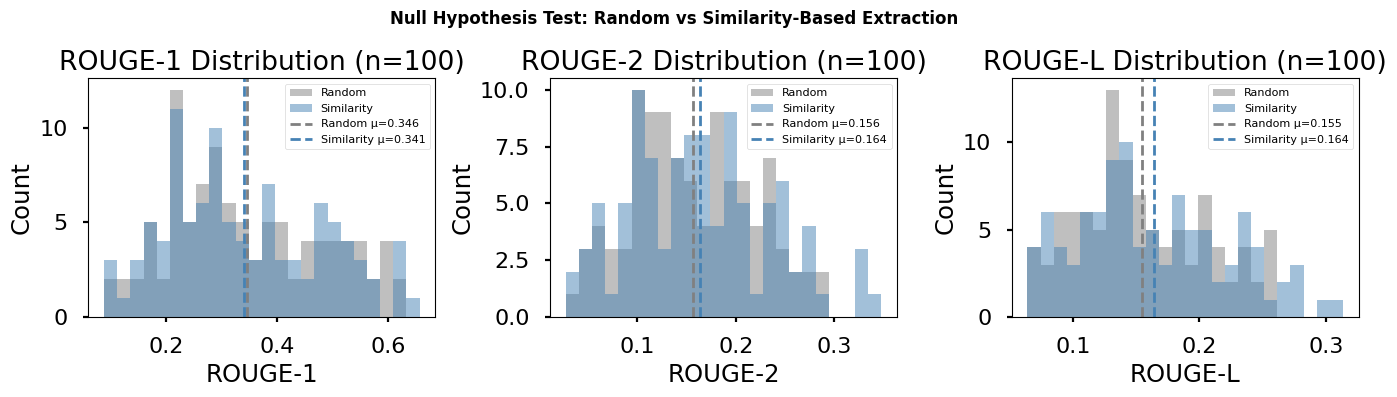

In [349]:
# Visualization: Distribution comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (metric, sim_arr, rand_arr) in zip(axes, [
    ('ROUGE-1', sim_r1, rand_r1),
    ('ROUGE-2', sim_r2, rand_r2),
    ('ROUGE-L', sim_rL, rand_rL)
]):
    # Histogram
    bins = np.linspace(min(sim_arr.min(), rand_arr.min()), 
                       max(sim_arr.max(), rand_arr.max()), 25)
    ax.hist(rand_arr, bins=bins, alpha=0.5, label='Random', color='gray')
    ax.hist(sim_arr, bins=bins, alpha=0.5, label='Similarity', color='steelblue')
    
    # Means
    ax.axvline(rand_arr.mean(), color='gray', linestyle='--', linewidth=2, label=f'Random μ={rand_arr.mean():.3f}')
    ax.axvline(sim_arr.mean(), color='steelblue', linestyle='--', linewidth=2, label=f'Similarity μ={sim_arr.mean():.3f}')
    
    ax.set_xlabel(metric)
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)
    ax.set_title(f'{metric} Distribution (n={N_BASELINE_DOCS})')

plt.suptitle('Null Hypothesis Test: Random vs Similarity-Based Extraction', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Experiment: Length Penalty (α) — Does It Help?

Now that we've validated similarity-based extraction beats random, let's test whether the length penalty improves things further:

**H₀:** Pure similarity (α=0) achieves the same ROUGE as similarity with length penalty (α=0.5)

**H₁:** Length penalty (α=0.5) improves ROUGE scores

We'll test multiple α values: 0.0, 0.25, 0.5, 1.0

In [350]:
import numpy as np
from rouge_score import rouge_scorer
from scipy import stats
from tqdm import tqdm

# Parameters
N_ALPHA_DOCS = 100
ALPHA_VALUES = [0.0, 0.25, 0.5, 1.0]
OBJECTIVE_PCT_ALPHA = 0.30

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Storage: {alpha: {'rouge1': [...], 'rouge2': [...], 'rougeL': [...]}}
rouge_by_alpha = {alpha: {'rouge1': [], 'rouge2': [], 'rougeL': []} for alpha in ALPHA_VALUES}

for doc_idx in tqdm(range(N_ALPHA_DOCS), desc="Documents"):
    example = govreport[doc_idx]
    report = example['report']
    reference = example['summary']
    
    # Compute features once
    features = processor.compute_document_features(report)
    sentences = features['sentences']
    tokens = features['tokens']
    similarities = features['similarities']
    ratios = features['ratios']
    
    total_tokens = tokens.sum()
    target_tokens = int(total_tokens * OBJECTIVE_PCT_ALPHA)
    
    # Test each alpha value
    for alpha in ALPHA_VALUES:
        scores = similarities - alpha * ratios
        ranked_indices = np.argsort(-scores)
        
        # Greedy selection
        selected = []
        current_tokens = 0
        for idx in ranked_indices:
            if current_tokens + tokens[idx] <= target_tokens:
                selected.append(idx)
                current_tokens += tokens[idx]
        
        # Extract text (preserve order)
        selected_sorted = sorted(selected)
        extracted_text = ' '.join([sentences[i] for i in selected_sorted])
        
        # ROUGE
        rouge = scorer.score(reference, extracted_text)
        rouge_by_alpha[alpha]['rouge1'].append(rouge['rouge1'].fmeasure)
        rouge_by_alpha[alpha]['rouge2'].append(rouge['rouge2'].fmeasure)
        rouge_by_alpha[alpha]['rougeL'].append(rouge['rougeL'].fmeasure)

print(f"Completed: {N_ALPHA_DOCS} documents, {len(ALPHA_VALUES)} α values")

Documents: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Completed: 100 documents, 4 α values

In [351]:
# Statistical analysis: α comparison
print("=" * 70)
print("LENGTH PENALTY EXPERIMENT: Comparing α values")
print("=" * 70)
print(f"\nN = {N_ALPHA_DOCS} documents, {OBJECTIVE_PCT_ALPHA:.0%} compression")
print()

# Summary table
print(f"{'α':<8} {'ROUGE-1':>16} {'ROUGE-2':>16} {'ROUGE-L':>16}")
print("-" * 60)

for alpha in ALPHA_VALUES:
    r1 = np.array(rouge_by_alpha[alpha]['rouge1'])
    r2 = np.array(rouge_by_alpha[alpha]['rouge2'])
    rL = np.array(rouge_by_alpha[alpha]['rougeL'])
    n = len(r1)
    print(f"{alpha:<8.2f} {r1.mean():.4f}±{r1.std()/np.sqrt(n):.4f}"
          f"   {r2.mean():.4f}±{r2.std()/np.sqrt(n):.4f}"
          f"   {rL.mean():.4f}±{rL.std()/np.sqrt(n):.4f}")

# Statistical tests: compare each α to α=0 (baseline)
print()
print("Paired t-test vs α=0 (pure similarity):")
print(f"{'α':<6} {'Metric':<10} {'Δ':>8} {'t-stat':>10} {'p-value':>12} {'Significant?':>14}")
print("-" * 62)

baseline_alpha = 0.0
for alpha in ALPHA_VALUES:
    if alpha == baseline_alpha:
        continue
    for metric in ['rouge1', 'rouge2', 'rougeL']:
        baseline = np.array(rouge_by_alpha[baseline_alpha][metric])
        treatment = np.array(rouge_by_alpha[alpha][metric])
        delta = treatment.mean() - baseline.mean()
        t_stat, p_val = stats.ttest_rel(treatment, baseline)
        sig = "✓ YES" if p_val < 0.05 else "✗ NO"
        metric_label = metric.upper().replace('ROUGE', 'R-')
        print(f"{alpha:<6.2f} {metric_label:<10} {delta:>+.4f} {t_stat:>10.2f} {p_val:>12.2e} {sig:>14}")
    print()

# Effect sizes
print("Effect sizes (Cohen's d) vs α=0:")
for alpha in ALPHA_VALUES:
    if alpha == baseline_alpha:
        continue
    print(f"  α={alpha}:")
    for metric in ['rouge1', 'rouge2', 'rougeL']:
        baseline = np.array(rouge_by_alpha[baseline_alpha][metric])
        treatment = np.array(rouge_by_alpha[alpha][metric])
        diff = treatment - baseline
        d = diff.mean() / diff.std() if diff.std() > 0 else 0
        magnitude = "large" if abs(d) > 0.8 else "medium" if abs(d) > 0.5 else "small"
        print(f"    {metric.upper()}: d = {d:+.3f} ({magnitude})")

======================================================================

LENGTH PENALTY EXPERIMENT: Comparing α values

======================================================================

N = 100 documents, 30% compression

α                 ROUGE-1          ROUGE-2          ROUGE-L

------------------------------------------------------------

0.00     0.3400±0.0138   0.1627±0.0071   0.1612±0.0057

0.25     0.3405±0.0139   0.1629±0.0071   0.1626±0.0058

0.50     0.3410±0.0140   0.1642±0.0072   0.1639±0.0059

1.00     0.3418±0.0141   0.1641±0.0073   0.1637±0.0060

Paired t-test vs α=0 (pure similarity):

α      Metric            Δ     t-stat      p-value   Significant?

--------------------------------------------------------------

0.25   R-1        +0.0005       1.66     9.99e-02           ✗ NO

0.25   R-2        +0.0002       0.39     6.97e-01           ✗ NO

0.25   R-L        +0.0014       3.12     2.40e-03          ✓ YES

0.50   R-1        +0.0010       1.54     1.27e-01           ✗ NO

0.50   R-2        +0.0015       1.86     6.58e-02           ✗ NO

0.50   R-L        +0.0027       3.53     6.32e-04          ✓ YES

1.00   R-1        +0.0019       1.95     5.36e-02           ✗ NO

1.00   R-2        +0.0015       0.92     3.61e-01           ✗ NO

1.00   R-L        +0.0025       2.46     1.55e-02          ✓ YES

Effect sizes (Cohen's d) vs α=0:

α=0.25:

ROUGE1: d = +0.167 (small)

ROUGE2: d = +0.039 (small)

ROUGEL: d = +0.313 (small)

α=0.5:

ROUGE1: d = +0.155 (small)

ROUGE2: d = +0.187 (small)

ROUGEL: d = +0.355 (small)

α=1.0:

ROUGE1: d = +0.196 (small)

ROUGE2: d = +0.092 (small)

ROUGEL: d = +0.247 (small)

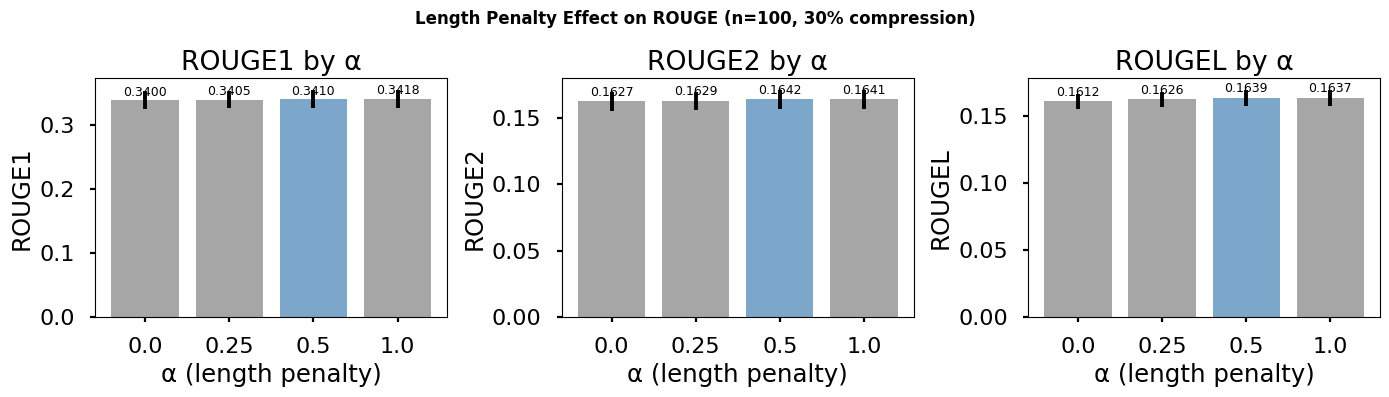

In [352]:
# Visualization: ROUGE by α
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, metric in zip(axes, ['rouge1', 'rouge2', 'rougeL']):
    means = [np.mean(rouge_by_alpha[a][metric]) for a in ALPHA_VALUES]
    sems = [np.std(rouge_by_alpha[a][metric]) / np.sqrt(N_ALPHA_DOCS) for a in ALPHA_VALUES]
    
    colors = ['steelblue' if a == 0.5 else 'gray' for a in ALPHA_VALUES]
    bars = ax.bar([str(a) for a in ALPHA_VALUES], means, yerr=sems, capsize=5, color=colors, alpha=0.7)
    
    ax.set_xlabel('α (length penalty)')
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} by α')
    
    # Add value labels
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{mean:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle(f'Length Penalty Effect on ROUGE (n={N_ALPHA_DOCS}, {OBJECTIVE_PCT_ALPHA:.0%} compression)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Experiment: Local vs Global Context Similarity

Since Model2Vec (static embeddings) has **no context window limit**, we can compute similarity between each sentence and the **full document** embedding. This "global similarity" could capture sentences representative of the entire document, not just their local neighborhood.

**Question:** Does global similarity provide additional signal beyond local similarity?

### Scoring formula with global context:
```
score = similarity_local - α × ratio + γ × similarity_global
```

We measure:
1. **Correlation** between local and global similarities
2. **Top-10 overlap** — do the same sentences rank highest for both signals?

In [343]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Use existing processor and documents from the notebook
N_EXPERIMENT_DOCS = 100

results_global = []

for doc_idx in tqdm(range(min(N_EXPERIMENT_DOCS, len(govreport))), desc="Processing documents"):
    text = govreport[doc_idx]['report']
    
    # Get local features (existing approach)
    features = processor.compute_document_features(text)
    sentences = features['sentences']
    local_sims = features['similarities']
    ratios = features['ratios']
    
    # Compute global similarity (sentence vs full document)
    sentence_embeddings = processor.embedding_model.encode(sentences)
    doc_embedding = processor.embedding_model.encode([text])
    global_sims = cosine_similarity(sentence_embeddings, doc_embedding).flatten()
    
    # Compute correlation
    corr = np.corrcoef(local_sims, global_sims)[0, 1]
    
    # Check top-10 overlap
    n_top = min(10, len(sentences))
    top_local_idx = np.argsort(local_sims)[-n_top:]
    top_global_idx = np.argsort(global_sims)[-n_top:]
    overlap = len(set(top_local_idx) & set(top_global_idx))
    
    results_global.append({
        'doc_idx': doc_idx,
        'n_sentences': len(sentences),
        'corr': corr,
        'overlap': overlap,
        'local_sims': local_sims,
        'global_sims': global_sims,
        'sentences': sentences,
        'ratios': ratios,
        'top_local_idx': top_local_idx,
        'top_global_idx': top_global_idx,
    })

print("\n" + "="*60)
print(f"SUMMARY ({N_EXPERIMENT_DOCS} documents)")
print("="*60)
print(f"Mean correlation (local vs global): {np.mean([r['corr'] for r in results_global]):.3f} ± {np.std([r['corr'] for r in results_global]):.3f}")
print(f"Mean top-10 overlap: {np.mean([r['overlap'] for r in results_global]):.1f}/10 ± {np.std([r['overlap'] for r in results_global]):.1f}")

Processing documents: 100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


============================================================

SUMMARY (100 documents)

============================================================

Mean correlation (local vs global): 0.620 ± 0.116

Mean top-10 overlap: 1.6/10 ± 1.5

IndexError: index 10 is out of bounds for axis 0 with size 10

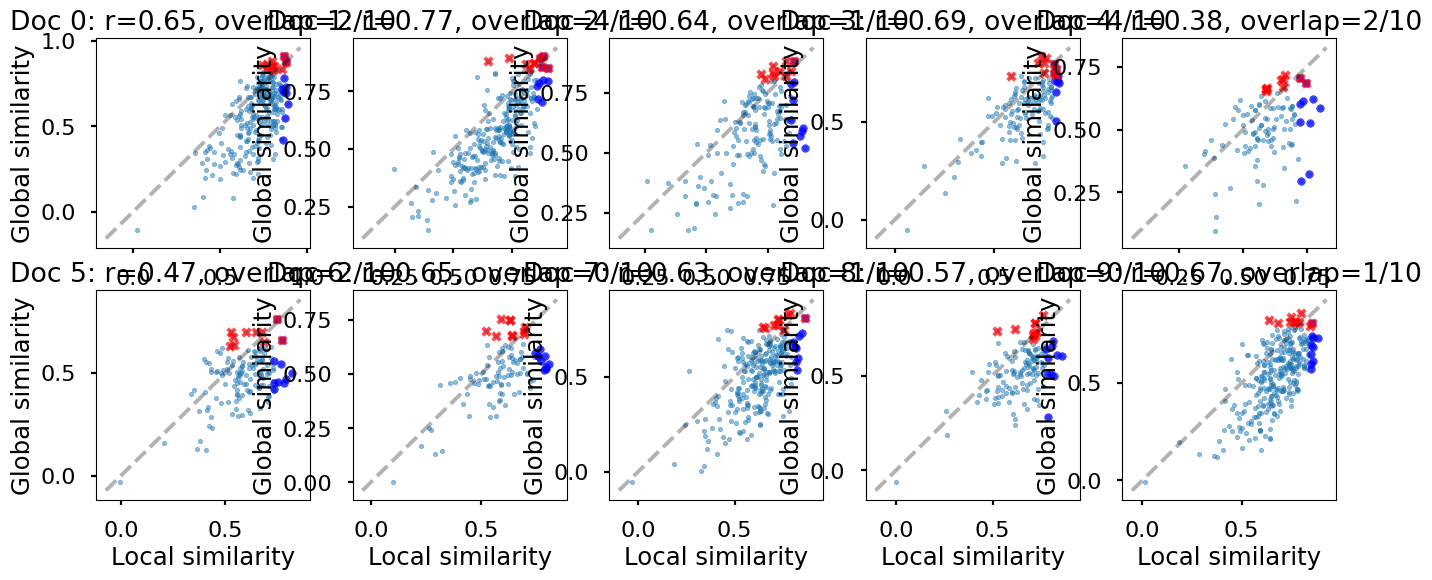

In [344]:
# Visualize: Local vs Global similarity scatter
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
axes = axes.flatten()

for i, r in enumerate(results_global):
    ax = axes[i]
    ax.scatter(r['local_sims'], r['global_sims'], alpha=0.5, s=10)
    
    # Highlight top-10 local (blue) and top-10 global (red)
    ax.scatter(r['local_sims'][r['top_local_idx']], r['global_sims'][r['top_local_idx']], 
               c='blue', s=30, label='Top local', alpha=0.7)
    ax.scatter(r['local_sims'][r['top_global_idx']], r['global_sims'][r['top_global_idx']], 
               c='red', s=30, marker='x', label='Top global', alpha=0.7)
    
    ax.set_xlabel('Local similarity')
    ax.set_ylabel('Global similarity')
    ax.set_title(f"Doc {i}: r={r['corr']:.2f}, overlap={r['overlap']}/10")
    
    # Add diagonal reference
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'k--', alpha=0.3)

axes[0].legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.suptitle('Local vs Global Similarity per Document', y=1.02)
plt.show()

In [345]:
# Examine sentences that differ between top-local and top-global
print("="*80)
print("SENTENCES IN TOP-10 GLOBAL BUT NOT TOP-10 LOCAL (Doc 0)")
print("="*80)

r = results_global[0]
global_only = set(r['top_global_idx']) - set(r['top_local_idx'])
local_only = set(r['top_local_idx']) - set(r['top_global_idx'])

print(f"\n🌍 Global-only sentences ({len(global_only)}):\n")
for idx in sorted(global_only):
    print(f"  [{idx}] local={r['local_sims'][idx]:.3f}, global={r['global_sims'][idx]:.3f}")
    print(f"      {r['sentences'][idx][:200]}...")
    print()

print(f"\n📍 Local-only sentences ({len(local_only)}):\n")
for idx in sorted(local_only):
    print(f"  [{idx}] local={r['local_sims'][idx]:.3f}, global={r['global_sims'][idx]:.3f}")
    print(f"      {r['sentences'][idx][:200]}...")
    print()

================================================================================

SENTENCES IN TOP-10 GLOBAL BUT NOT TOP-10 LOCAL (Doc 0)

================================================================================

🌍 Global-only sentences (8):

[7] local=0.805, global=0.832

DOD has established force health protection and surveillance policies aimed at assessing and reducing or 
preventing health risks for its deployed federal civilian personnel; however, the department la...

[12] local=0.771, global=0.866

The DOD components included in our review lacked documentation to show that they always implemented force 
health protection and surveillance requirements for deployed federal civilians....

[14] local=0.800, global=0.854

DOD’s force health protection and surveillance policies require the components to assess the medical 
condition of federal civilians to ensure that only medically fit personnel deploy outside of the Un...

[30] local=0.772, global=0.837

DOD’s force health protection and surveillance policies also require returning DOD federal civilian personnel
to undergo post-deployment health assessments to document current health status, experienc...

[48] local=0.799, global=0.882

With increases in the department’s use of federal civilian personnel to support military operations, DOD 
officials have recognized the need for more complete and centralized location-specific deployme...

[158] local=0.854, global=0.836

To strengthen DOD’s force health protection and surveillance for its federal civilian personnel who deploy in
support of contingency operations, we recommend that the Secretary of Defense direct the O...

[162] local=0.810, global=0.850

Specifically, the department stated that it has written and coordinated a new DOD instruction, scheduled to 
become effective before the end of 2006, that establishes a comprehensive DOD force health p...

[196] local=0.740, global=0.861

To assess the extent to which DOD has established force health protection and surveillance policies for DOD 
federal civilians who deploy outside of the United States in support of contingency operatio...

📍 Local-only sentences (8):

[17] local=0.869, global=0.780

Our review of deployment records and other documentation at the selected component locations found that these
components lacked documentation to show that some federal civilian personnel who deployed ...

[55] local=0.867, global=0.703

In response to a legislative mandate and our recommendation, DOD established an oversight mechanism to 
evaluate the success of its force health protection and surveillance policies in ensuring that se...

[85] local=0.880, global=0.732

DOD federal civilian and military personnel are both eligible to receive special pays to compensate them for 
the conditions of deployment....

[94] local=0.857, global=0.721

Although DOD federal civilian and military personnel generally receive various special pays to compensate 
them for conditions of deployment, in certain scenarios that we modeled, the overall amounts o...

[104] local=0.862, global=0.423

We found that VA compensation payments for military personnel were based on a disability rating, regardless 
of salary level; in contrast, compensation payments for civilian public safety officers were...

[122] local=0.872, global=0.549

When an injury is severe enough to be deemed permanent and total, DOD federal civilian and military personnel
may receive similar types of benefits such as disability compensation and retirement payme...

[146] local=0.892, global=0.633

Survivors of both deceased DOD federal civilian and military personnel may be eligible to receive recurring 
Social Security payments based on the deceased individual’s earnings in a covered period....

[206] local=0.879, global=0.697

At all eight component locations, we reviewed either all available hard copy or electronic deployment 
records, or in one instance, a sample of the deployment records for deployed federal civilian pers...

In [346]:
# Test: Does adding global similarity improve selection quality?
# Compare ROUGE scores: local-only vs local+global

from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

GAMMA_VALUES = [0.0, 0.1, 0.25, 0.5]  # Weight for global similarity
OBJECTIVE_PCT = 0.3

rouge_by_gamma = {gamma: {'rouge1': [], 'rouge2': [], 'rougeL': []} for gamma in GAMMA_VALUES}

for doc_idx, r in tqdm(enumerate(results_global), total=len(results_global), desc="Computing ROUGE"):
    reference = govreport[doc_idx]['summary']
    sentences = r['sentences']
    local_sims = r['local_sims']
    global_sims = r['global_sims']
    ratios = r['ratios']
    tokens = np.array([len(processor.encoder.encode(s)) for s in sentences])
    
    total_tokens = tokens.sum()
    target_tokens = int(total_tokens * OBJECTIVE_PCT)
    
    for gamma in GAMMA_VALUES:
        # Score: local - α*ratio + γ*global
        scores = local_sims - ALPHA * ratios + gamma * global_sims
        
        # Greedy selection
        ranked_idx = np.argsort(scores)[::-1]
        mask = np.zeros(len(sentences), dtype=int)
        current_tokens = 0
        
        for idx in ranked_idx:
            if current_tokens + tokens[idx] <= target_tokens:
                mask[idx] = 1
                current_tokens += tokens[idx]
        
        # Build selected text
        selected = [s for s, m in zip(sentences, mask) if m == 1]
        selected_text = " ".join(selected)
        
        # Compute ROUGE
        rouge = scorer.score(reference, selected_text)
        rouge_by_gamma[gamma]['rouge1'].append(rouge['rouge1'].fmeasure)
        rouge_by_gamma[gamma]['rouge2'].append(rouge['rouge2'].fmeasure)
        rouge_by_gamma[gamma]['rougeL'].append(rouge['rougeL'].fmeasure)

# Summary table with standard errors
import scipy.stats as stats
n = len(results_global)

print(f"ROUGE scores at {OBJECTIVE_PCT:.0%} compression (α={ALPHA}, n={n}):\n")
print(f"{'γ (global)':<12} {'ROUGE-1':<16} {'ROUGE-2':<16} {'ROUGE-L':<16}")
print("-" * 60)
for gamma in GAMMA_VALUES:
    r1_mean = np.mean(rouge_by_gamma[gamma]['rouge1'])
    r2_mean = np.mean(rouge_by_gamma[gamma]['rouge2'])
    rL_mean = np.mean(rouge_by_gamma[gamma]['rougeL'])
    r1_se = np.std(rouge_by_gamma[gamma]['rouge1']) / np.sqrt(n)
    r2_se = np.std(rouge_by_gamma[gamma]['rouge2']) / np.sqrt(n)
    rL_se = np.std(rouge_by_gamma[gamma]['rougeL']) / np.sqrt(n)
    print(f"{gamma:<12.2f} {r1_mean:.4f}±{r1_se:.4f}  {r2_mean:.4f}±{r2_se:.4f}  {rL_mean:.4f}±{rL_se:.4f}")

# Statistical significance test (paired t-test: γ=0.25 vs γ=0)
print("\n" + "="*60)
print("Statistical significance (paired t-test, γ=0.25 vs γ=0):")
for metric in ['rouge1', 'rouge2', 'rougeL']:
    baseline = rouge_by_gamma[0.0][metric]
    treatment = rouge_by_gamma[0.25][metric]
    t_stat, p_val = stats.ttest_rel(treatment, baseline)
    delta = np.mean(treatment) - np.mean(baseline)
    sig = "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"  {metric}: Δ={delta:+.4f}, t={t_stat:.2f}, p={p_val:.4f} {sig}")

Computing ROUGE: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


ROUGE scores at 30% compression (α=0.5, n=100):

γ (global)   ROUGE-1          ROUGE-2          ROUGE-L

------------------------------------------------------------

0.00         0.3410±0.0140  0.1642±0.0072  0.1639±0.0059

0.10         0.3411±0.0140  0.1644±0.0073  0.1642±0.0059

0.25         0.3410±0.0139  0.1644±0.0072  0.1650±0.0059

0.50         0.3394±0.0138  0.1642±0.0070  0.1639±0.0058

============================================================

Statistical significance (paired t-test, γ=0.25 vs γ=0):

rouge1: Δ=+0.0000, t=0.05, p=0.9614

rouge2: Δ=+0.0002, t=0.19, p=0.8498

rougeL: Δ=+0.0010, t=0.95, p=0.3448

### Interpretation

**If correlation is high (> 0.7):** Local and global signals are redundant — global adds little new information.

**If correlation is low but ROUGE improves with γ > 0:** Global captures different (and useful) sentences.

**If ROUGE stays flat or decreases:** Global similarity may be capturing vocabulary overlap rather than information density.